In [381]:
import numpy as np
import scipy.integrate as sci
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numba as nb
from sklearn.metrics import r2_score

In [382]:
@nb.njit
def find_intercepts(x, y, z, plane_height):
    """
    Identify the intercepts where a 3D trajectory crosses a horizontal plane at a specified height.
    
    Parameters:
    - x (array of float): The x-coordinates of the trajectory.
    - y (array of float): The y-coordinates of the trajectory.
    - z (array of float): The z-coordinates of the trajectory, representing vertical position.
    - plane_height (float): The height of the plane to check for intercepts.
    
    Returns:
    - tuple of arrays: Two arrays containing the x and y coordinates of the points where the trajectory crosses the specified height.
    """
    x_intercept = []
    y_intercept = []
    for i in range(len(z) - 1):
        if z[i] < plane_height and z[i + 1] > plane_height:
            x_intercept.append(x[i])
            y_intercept.append(y[i])
    return np.array(x_intercept), np.array(y_intercept)

@nb.njit
def smk(x, y, m, k):
    """
    Generate a subset of points from a 2D trajectory using a sliding window approach.
    
    Parameters:
    - x (array of float): The x-coordinates of the trajectory.
    - y (array of float): The y-coordinates of the trajectory.
    - m (int): The size of the sliding window.
    - k (int): The step size between successive windows.
    
    Returns:
    - ndarray: A 2D NumPy array containing points sampled according to the sliding window parameters.
    """
    N = len(x)
    num_points = int(np.floor((N - m) / k))
    s = np.empty((num_points, 2))  # Pre-allocate a NumPy array
    for i in range(num_points):
        index = m + (i * k) - 1
        s[i, 0] = x[index]
        s[i, 1] = y[index]
    return s

@nb.njit
def lmk(x, y, m, k):
    """
    Calculate the approximate length of segments of a 2D trajectory using a sliding window.
    
    Parameters:
    - x (array of float): The x-coordinates.
    - y (array of float): The y-coordinates.
    - m (int): The size of the sliding window.
    - k (int): The step size between successive windows.
    
    Returns:
    - float: The scaled average distance covered in each segment of the trajectory.
    """
    points = smk(x, y, m, k)
    total_distance = 0.0
    for i in range(len(points) - 1):
        total_distance += np.linalg.norm(points[i + 1] - points[i])
    if len(points) > 1:
        return (total_distance * (len(x) - m)) / (k * (len(points) - 1))
    else:
        return 0.0


@nb.njit
def lk(x, y, k):
    """
    Compute the average length of a 2D trajectory using multiple sliding windows to enhance accuracy.
    
    Parameters:
    - x (array of float): The x-coordinates.
    - y (array of float): The y-coordinates.
    - k (int): The number of sliding windows to apply.
    
    Returns:
    - float: The average length computed over all specified window configurations.
    """
    moyenne = 0.0
    for m in range(1, k + 1):
        moyenne += lmk(x, y, m, k)
    return moyenne / k

@nb.njit
def lk_for_k(x, y, z, height, ks=np.arange(1, 20)):
    """
    Apply the Lk method to compute the trajectory length for various configurations of sliding window sizes, 
    evaluated at the intercepts with a specified horizontal plane.
    
    Parameters:
    - x (array of float): The x-coordinates of the trajectory.
    - y (array of float): The y-coordinates of the trajectory.
    - z (array of float): The z-coordinates of the trajectory.
    - height (float): The height of the plane to find intercepts.
    - ks (array of int, optional): The range of k-values (window sizes) to use.
    
    Returns:
    - tuple: Two arrays, the first containing the k-values used, and the second containing the logarithm of the Lk lengths.
    """
    x_intercept, y_intercept = find_intercepts(x, y, z, height)
    l_de_k = np.zeros(len(ks), dtype=np.float64)
    for i in range(len(ks)):
        l_de_k[i] = lk(x_intercept, y_intercept, ks[i])
    return ks, np.log(l_de_k)

@nb.njit
def average_difference(points):
    """
    Calculate the average difference between consecutive values in a 1D list using Numba for performance optimization.

    Parameters:
    - points (array of float/int): Array of numeric values.

    Returns:
    - float: The average difference between each successive value.
    """
    n = len(points)
    if n < 2:
        return 0.0  # Return 0 if there are not enough points to compare

    total_difference = 0.0
    # Loop through the array of points and calculate the difference between consecutive points
    for i in range(1, n):
        difference = abs(points[i] - points[i-1])
        total_difference += difference

    # Calculate the average difference
    average_diff = total_difference / (n - 1)
    return average_diff


def optimise_plane_lk(x, y, z, height_start=5, height_stop=25, step=1):
    """
    Optimise the plane height to find the height that maximizes the average difference 
    in the logarithm of the trajectory lengths calculated by the Lk method.

    This function iterates through a range of plane heights and determines the height
    at which the average difference of the logarithm of lengths of trajectories, 
    intercepted at each height, is maximized.

    Parameters:
    - x (array of float): The x-coordinates of the trajectory.
    - y (array of float): The y-coordinates of the trajectory.
    - z (array of float): The z-coordinates of the trajectory.
    - height_start (int): The starting height of the plane.
    - height_stop (int): The ending height of the plane.
    - step (int): The increment step between heights.

    Returns:
    - float: The height that maximizes the average difference of the logarithmic lengths.
    """
    possible_height = np.arange(height_start, height_stop, step)
    max_moy = 0
    for h in possible_height:
        lk_of_k = lk_for_k(x, y, z, h)[1]
        moyenne_dy = average_difference(lk_of_k)
        if moyenne_dy > max_moy:
            max_moy = moyenne_dy
            best_height = h
    return best_height

@nb.njit
def rk4_step(x, y, z, dt, function):
    """
    Perform one step of the Runge-Kutta 4th order method for solving a system of ODEs.

    Parameters:
    - x, y, z: Arrays of x, y, and z coordinates of the trajectory.
    - dt: Time step.

    Returns:
    - x_new, y_new, z_new: Arrays of new x, y, and z coordinates of the trajectory.
    """
    k1_x, k1_y, k1_z = function(x, y, z)
    k2_x, k2_y, k2_z = function(x + 0.5 * dt * k1_x, y + 0.5 * dt * k1_y, z + 0.5 * dt * k1_z)
    k3_x, k3_y, k3_z = function(x + 0.5 * dt * k2_x, y + 0.5 * dt * k2_y, z + 0.5 * dt * k2_z)
    k4_x, k4_y, k4_z = function(x + dt * k3_x, y + dt * k3_y, z + dt * k3_z)
    x_new = x + (dt / 6.0) * (k1_x + 2 * k2_x + 2 * k3_x + k4_x)
    y_new = y + (dt / 6.0) * (k1_y + 2 * k2_y + 2 * k3_y + k4_y)
    z_new = z + (dt / 6.0) * (k1_z + 2 * k2_z + 2 * k3_z + k4_z)
    return x_new, y_new, z_new


# Lorenz

In [383]:
@nb.njit
def lorenz(x, y, z, sigma=10.0, rho=28.0, beta=(8.0/3.0)):
    """
    Calculate the length of a 2D trajectory using the Lk method for a range of k values.

    Parameters:
    - x, y, z: Arrays of x, y, and z coordinates of the trajectory.
    - height: Height of the plane for finding intercepts.
    - k: Array of k values to use in the Lk method.

    Returns:
    - k: Array of k values used in the Lk method.
    - l_de_k: Array of log of Lk values for each k value.
    """
    x_dot = sigma * (y - x)
    y_dot = x * (rho - z) - y
    z_dot = x * y - beta * z
    return x_dot, y_dot, z_dot

@nb.njit(parallel=True)
def solve_lorenz(x0=0.0, y0=1.0, z0=1.05, dt=0.01, num_steps=1000000):
    """
    Solve the Lorenz system of ODEs using the Runge-Kutta 4th order method.
    """
    x, y, z = np.zeros(num_steps + 1), np.zeros(num_steps + 1), np.zeros(num_steps + 1)
    x[0], y[0], z[0] = x0, y0, z0
    for i in nb.prange(num_steps):
        x[i + 1], y[i + 1], z[i + 1] = rk4_step(x[i], y[i], z[i], dt, lorenz)
    return x, y, z

# Noise

In [384]:
@nb.njit
def generate_noise_trajectory(num_points):
    """
    Generate a 3D noise trajectory.

    Parameters:
    - num_points: Number of points in the trajectory.

    Returns:
    - Arrays for x, y, and z coordinates of the noise trajectory.
    """
    x = np.random.randn(num_points)
    y = np.random.randn(num_points)
    z = np.random.randn(num_points)
    return x, y, z

@nb.njit
def determine_x_y_noise(points, height):
    """
    Generate a 3D noise trajectory and find the intercepts with a given plane.

    Parameters:
    - points: Number of points in the trajectory.
    - height: Height of the plane.

    Returns:
    - x_intercept, y_intercept: Arrays of x and y coordinates of the intercepts.
    """
    x, y, z = generate_noise_trajectory(points)
    return find_intercepts(x, y, z, height)

In [385]:
x,y,z = solve_lorenz()
x_intercept, y_intercept = find_intercepts(x,y,z,13.979999999999809)

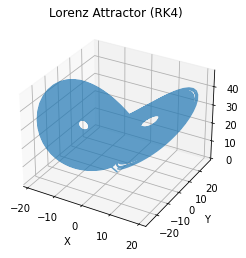

In [386]:
# Plot the Lorenz attractor
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(x, y, z, alpha=0.7)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Lorenz Attractor (RK4)')

plt.show()

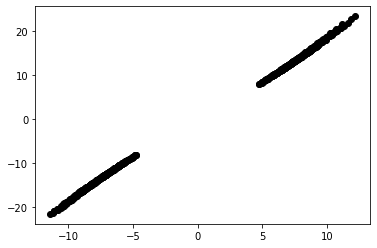

In [387]:
plt.plot(x_intercept, y_intercept, marker = 'o', linestyle = '', color = 'black')
plt.show()

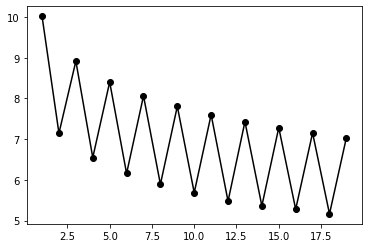

In [388]:
K, l_of_k = lk_for_k(x,y,z,13.979999999999809)
plt.plot(K, l_of_k, marker = 'o', linestyle = '-', color = 'black')
plt.show()

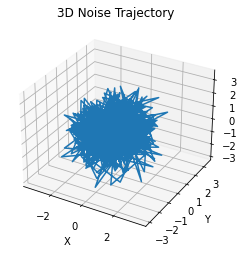

In [389]:
# Generate arrays for x, y, and z coordinates of the noise trajectory
x_noise, y_noise, z_noise = generate_noise_trajectory(1000)

# Plot the 3D noise trajectory
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(x_noise, y_noise, z_noise)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Noise Trajectory')

plt.show()

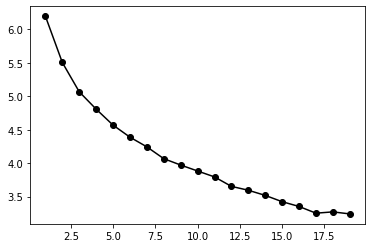

In [390]:
x_noise, y_noise = determine_x_y_noise(100000, 0.1)
K_noise, lk_of_k_noise = lk_for_k(x=x_noise,y=y_noise,z=z_noise,height=0.1)
plt.plot(K_noise, lk_of_k_noise, marker = 'o', linestyle = '-', color = 'black')
plt.show()